## Face loaclization
For face loacalization we have used face_locatization library, which works preety good

In [ ]:
## Only for colab
# !pip install face_recognition
# from google.colab import drive
# drive.mount('/gdrive')
# import os 
# os.chdir('/gdrive/My Drive/Face Locatlization and Emotion Detection')
# from IPython.display import clear_output

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
import face_recognition
import matplotlib.pyplot as plt 
import cv2
import pandas as pd 
import numpy as np 
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from torchvision.models import squeezenet1_0
from torch.autograd import Variable
from torch.utils.tensorboard import SummaryWriter

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Loading a new image and extracting face from it


In [33]:
# Image loading and face localization
image = face_recognition.load_image_file("sample.jpg",mode='L')
face_locations = face_recognition.face_locations(image, number_of_times_to_upsample=2 ) # returns (top right bottm left)
print(type(image),image.shape)

<class 'numpy.ndarray'> (402, 602)


In [34]:
face_locations[0]

(241, 350, 286, 305)

Faces count is : 9


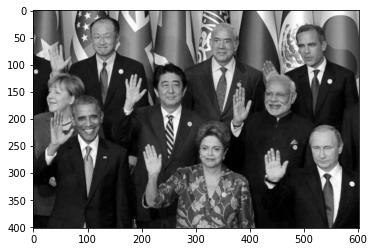

In [35]:
## Displaying image
plt.imshow(image, cmap="gray");
print("Faces count is : {}".format(len(face_locations)))

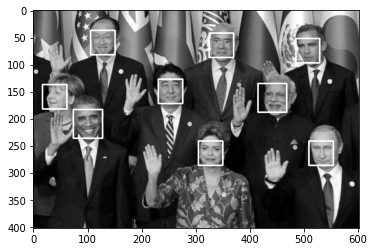

In [36]:
## plotting detected faces
for x in face_locations:
    start_point = (x[3], x[0]) 
    end_point = (x[1], x[2]) 
    color = (255, 0, 0) 
    thickness = 2
    image2 = cv2.rectangle(image, start_point, end_point, color, thickness) 
plt.imshow(image, cmap="gray")

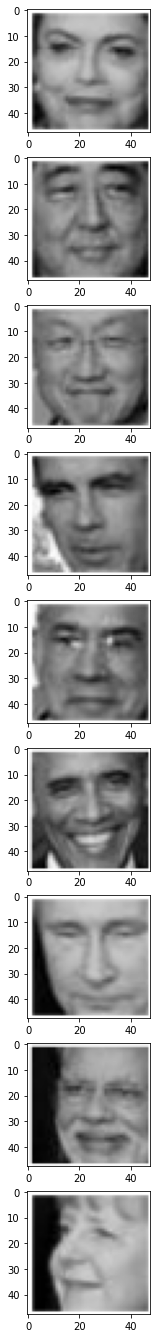

In [37]:
## Cropping all the image and displaying them
fig=plt.figure(figsize=(24, 24))
columns = 1
rows=(len(face_locations))
for i,faces in enumerate(face_locations,1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(cv2.resize(image[faces[0]:faces[2],faces[3]:faces[1]],(48,48)), cmap="gray") ## We are training data on 48*48 images
plt.show()

## Dataset Description
The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centered and occupies about the same amount of space in each image. The task is to categorize each face based on the emotion shown in the facial expression in to one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral).

train.csv contains two columns, "emotion" and "pixels". The "emotion" column contains a numeric code ranging from 0 to 6, inclusive, for the emotion that is present in the image. The "pixels" column contains a string surrounded in quotes for each image. The contents of this string a space-separated pixel values in row major order. test.csv contains only the "pixels" column and your task is to predict the emotion column.


In [38]:
index_to_emotion=('Angry', 'Disgust','Fear', 'Happy', 'Sad', 'Surprise', 'Neutral')

In [39]:
dataframe = pd.read_csv('data.csv')
dataframe

emotion                                             pixels        Usage
0            0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...     Training
1            0  151 150 147 155 148 133 111 140 170 174 182 15...     Training
2            2  231 212 156 164 174 138 161 173 182 200 106 38...     Training
3            4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...     Training
4            6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...     Training
...        ...                                                ...          ...
35882        6  50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...  PrivateTest
35883        3  178 174 172 173 181 188 191 194 196 199 200 20...  PrivateTest
35884        0  17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...  PrivateTest
35885        3  30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...  PrivateTest
35886        2  19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...  PrivateTest

[35887 rows x 3 columns]

### Visualizing data distribution

In [ ]:
# distribution plot for emotion
dataframe['emotion'].value_counts().plot(kind='bar')

In [ ]:
## plotting for train test split
dataframe['Usage'].value_counts().plot(kind='bar')

#### For train test split we have taken Training as training data and other two as testing data

In [ ]:
## data distribution based on Traning dataset
dataframe['emotion'][dataframe['Usage']=='Training'].value_counts().plot(kind='bar')

In [ ]:
## Data distribution based on Testing dataset
dataframe['emotion'][dataframe['Usage']!='Training'].value_counts().plot(kind='bar')

#### We have similar distribution of both training and testing data  
#### But, the data distribution for Disgust(label encoded as 1) is quite significantly lesser.  
#### Our model may not be able to predict disgust faces

## Building image from pixels values

In [ ]:
x=dataframe.iloc[2][1]
print(len(x.split(' ')) , 48*48)
x=x.split(' ')

In [ ]:
image=[]
iterator =[i for i in  range(0,2352,48)]
for i in range(len(iterator)-1):
    try:
        start=iterator[i]
        end=iterator[i+1]
        image.append(x[start:end])
        #print(i)
    except:
        print("Error")
len(image)

In [ ]:
image = np.array(image)
image = image.astype(np.uint8)
#plt.imshow(transform['train'](image)[0], cmap="gray")
plt.imshow(image, cmap="gray")

In [ ]:
image.shape

### Faces of model training data and the face extracted from an image are very much similar.

# Model
A standered CNN calssifier is trained to predict the emotion of a face  
Model is build in pytorch

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv_layers=nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.5),
            nn.Conv2d(64, 128, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.linear_layers=nn.Sequential(
            nn.Linear(10368, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(1024, 7),
            nn.Softmax(),
        )
    def forward(self, x):
        out = self.conv_layers(x)
        out = out.reshape(out.size(0), -1)
        out = self.linear_layers(out)
        return out
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)
    elif type(m) == nn.Conv2d:
        torch.nn.init.xavier_uniform(m.weight)
model = ConvNet()
model.to(device)
model.apply(init_weights)

In [ ]:
# Transforms 
transform = {
    'train':transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        ]),
    'test':transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
    ])
}

In [ ]:
# Building dataset class
class get_dataset(Dataset):
    def __init__(self, train_test, transforms):
        self.transforms = transforms
        self.train = (train_test == 'train')
        dataframe = pd.read_csv('data.csv')
        if self.train:
            dataframe = dataframe[dataframe['Usage'] == 'Training']
        else:
            dataframe = dataframe[dataframe['Usage'] != 'Training']
        print("Train : {}, found {} vectors".format(self.train,len(dataframe)))
        self.len=len(dataframe)
        self.images = torch.zeros((len(dataframe),1,48,48))
        self.targets= torch.zeros((len(dataframe),7))
        print("Building {} dataset".format(train_test))
        for index in tqdm(range(self.len)):
            self.targets[index][dataframe.iloc[index][0]] = 1
            image_data = dataframe.iloc[index][1]
            image_data = image_data.split(' ')
            image = []
            iterator =[i for i in  range(0,2352,48)]
            for i in range(len(iterator)-1):
                start=iterator[i]
                end=iterator[i+1]
                image.append(image_data[start:end])
            image = np.array(image)
            image = image.astype(np.uint8)
            self.image = image
            self.images[index][0]=torch.from_numpy(image)
    def __getitem__(self, index):
        if self.transforms:
            return self.transforms(self.images[index]),self.targets[index]
        else:
            return self.images[index],self.targets[index]
 
    def __len__(self):
        return self.len

In [ ]:
## Creating objects of train and test datasets
train_dataset = get_dataset('train',transforms = transform['train'])
test_dataset = get_dataset('test',transforms = transform['test'])

In [ ]:
# Creating dataloader objects
print("Building train loader")
trainloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
print("Building Test loader")
testloader = DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=3)

In [ ]:
# Using Mean squared error loss
#criterion = nn.MultiLabelSoftMarginLoss()
#criterion = nn.BCEWithLogitsLoss()
criterion = nn.CrossEntropyLoss()
#criterion = nn.MSELoss()
criterion.to(device)

In [ ]:
# Using SGD optimizer 
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.5)

In [ ]:
# Training model saved path and logs file name
path = 'emotion_detection.pth'
logs = 'logs.csv'

In [ ]:
#  Removing previously logs file and Inintilizing log file 
#! rm logs.csv
#with open(logs,'a+') as file:
#    file.write('Total Epochs,Epoch,Step,Running Loss,Test Loss\n')

In [ ]:
def resume(model,logs_file,saved_model_weight):
    '''
    returns 
        model(nn.Module):Pytorch model
        epoch(int): completed epochs
    '''
    model.cpu()
    model.load_state_dict(torch.load(saved_model_weight))
    model.to(device)
    logs = pd.read_csv(logs_file)
    epoch=int(logs.iloc[len(logs)-1][1])
    steps = int(logs.iloc[len(logs)-1][2])
    return model,epoch,steps

In [ ]:
## Removig previous tensorboard log files 
#! rm -rf runs/*

In [ ]:
##  For showing output in tensorboard
# helper functions

def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    img = img.cpu()
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds_tensor=preds_tensor.cpu()
    preds = np.squeeze(preds_tensor.numpy())
    #return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]
    return preds, [el[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    labels=torch.max(labels,1)[1]
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(24, 24))
    rows=2
    columns=5
    for idx in np.arange(10):
        ax = fig.add_subplot(rows, columns, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            index_to_emotion[preds[idx]],
            probs[idx] * 100.0,
            index_to_emotion[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig
writer = SummaryWriter('runs/emotion_detection')

In [ ]:
# starting tensorboard
%tensorboard --logdir ./

In [ ]:
## loading saved model
model,epoch,steps=resume(model,logs,path)

In [ ]:
epochs = 2000
epoch = epoch if 'epoch' in locals() else 0
steps = steps if 'steps' in locals() else 0
running_loss = 0
print_every = 100
train_losses, test_losses, accuracys = [], [], []
for epoch in range(epoch,epochs):
    for i, data  in enumerate(trainloader):
        inputs, labels = data
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps,torch.max(labels, 1)[1] )
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device),labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, torch.max(labels, 1)[1])
                    test_loss += batch_loss.item()
                    #ps = torch.exp(logps)
                    #top_p, top_class = ps.topk(1, dim=1)
                    #equals = top_class == labels.view(*top_class.shape)
                    #accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/print_every)
            test_losses.append(test_loss/len(testloader))
            #train_losses.append(running_loss/print_every)
            #test_losses.append(running_loss)                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.10f}.. "
                  f"Test loss: {test_loss/len(testloader):.10f}.. ")
            with open(logs,'a+') as file:
                file.write(f"{epochs},{epoch+1},{steps},{running_loss/print_every:.10f},{test_loss/len(testloader):.10f}\n")
            # Adding result to tensorboard
            writer.add_scalar('training loss',running_loss / print_every, epoch * len(trainloader) + i)
            writer.add_scalar('Validation loss',test_loss/ print_every, epoch * len(trainloader) + i)
            writer.add_figure('predictions vs. actuals',plot_classes_preds(model, inputs, labels),global_step=epoch * len(trainloader) + i)
            running_loss = 0
            model.train()
    # Saving model every epoch 
    model.cpu()
    torch.save(model.state_dict(), path)
    model.to(device)
    if epoch % 10 == 0:
        clear_output()
        print(labels)
        print(logps)

In [ ]:
!kill 6006